In [42]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bigfile import BigFile
import glob,os,struct
# from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology

import seaborn as sns

sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import pickle
import warnings


In [40]:
!pip install bigfile

In [43]:
# some constants and unit conversions
msun_mks = 1.989e30
pc_mks = 3.086e16
grav_mks = 6.67e-11
km_mks = 1e3
yr_mks = 3.154e+7
c_mks = 3e8

Mpc_to_m = 3.086e+22
m_to_Mpc = 1./Mpc_to_m
s_to_year = 3.17098e-8
c_Mpc_yr = c_mks*m_to_Mpc/s_to_year


## read summary statistics from PIG files

### basic snapshot info

In [3]:
# z=3 snap: 214
# z=2 snap: 348

snap = 348

In [44]:

pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_%03d_subfind'%snap)

# you can check the redshift by reading the attributes of the snapshot
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('Lbox = %d ckpc/h'%Lbox)
print('NfofGroups = %d'%Nfof)

print('------ cosmological parameters -----')
print('h = %.4f'%hh)
print('Omega_m = %.4f'%om0)
print('Omega_b = %.4f'%omb)
print('Omega_l = %.4f'%oml)

----------PIG file info------------
Redshift = 2.00
Lbox = 250000 ckpc/h
NfofGroups = 186046367
------ cosmological parameters -----
h = 0.6774
Omega_m = 0.3089
Omega_b = 0.0486
Omega_l = 0.6911


In [45]:
battr['MassTable']

array([1.26680398e-04, 6.74773361e-04, 0.00000000e+00, 0.00000000e+00,
       3.16700995e-05, 3.16700995e-05])

In [46]:
# set-up cosmology
params = {'flat': True, 'H0': 100*hh, 'Om0': om0, 'Ob0': omb, 'sigma8': sigma8, 'ns': 0.96}
cosmo = cosmology.setCosmology('myCosmo', params)

# conversion between time and redshift
z_arr = np.linspace(0,20,1000)
time = cosmo.age(z_arr) # Gyr
def z_to_t(x):
    return interp1d(z_arr, time,fill_value='extrapolate')(x)
def t_to_z(x):
    return interp1d(time, z_arr,fill_value='extrapolate')(x) 

In [47]:
# from snapshot number to redshift
snaps = np.loadtxt('/hildafs/datasets/Asterix/PIG2/Snapshots.txt')
snap2z = {s[0]:1./s[1]-1 for s in snaps}
snap2z[348]

2.0000030000030002

In [49]:
# ff = "/hildafs/home/nianyic/scratch1/testruns/timestep_L25/output/PART_006"
# part = BigFile(ff)
# # you can check the redshift by reading the attributes of the snapshot
# battr = part["Header"].attrs
# print(''.join(battr["CodeVersion"]))

### read group summary statistics: halo mass function

Group (aka "halo") information such as the total mass, angular momentum is stored in "FOFGroups/*".

Particle types:
0: Gas; 1: Dark Matter; 4: Star; 5: Black hole

Here we plot the halo mass (i.e. sum of all dark matter in each halo).

"Mass function" is basically a volume-normalized histogram.

In [50]:
# *1e10/hh to convert from simulation mass unit into Msun
# groups are ordered by total mass, here I load in the first 5000,000 groups and it should include most of the massive halos
MassByType = pig.open('FOFGroups/MassByType')[:5000000]*1e10/hh
MassByType.shape

(5000000, 6)

In [52]:
def mass_func(m,Lbox,lim_min,lim_max,nbin):
    bins = np.logspace(lim_min,lim_max,nbin)
    center = np.log10(bins)[:-1]+np.diff(np.log10(bins))/2
    count = np.histogram(m,bins)

    mask = count[0]>0
    fac = np.diff(np.log10(bins))*(Lbox/hh)**3
    yy = count[0]/fac
    err = yy[mask]/np.sqrt(count[0][mask])
    y1 = yy[mask]+err
    y2 = yy[mask]-err
    y2[y2<=0] = 1e-50
    return np.power(10,center[mask]),yy[mask], y1, y2


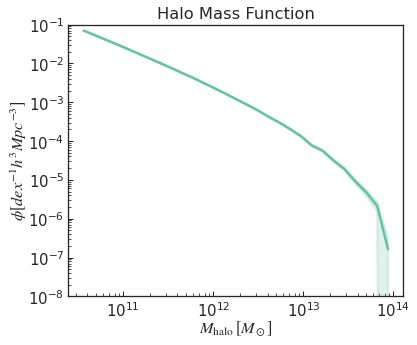

In [53]:
mass_dm = MassByType[:,1] # "1" is the dm particle type

x1,y1,y_lower,y_upper = mass_func(mass_dm,Lbox=Lbox/1000,lim_min=10.5,lim_max=14,nbin=30)

fig,ax = plt.subplots(figsize=(6,5),ncols=1,nrows=1)
ax.plot(x1,y1,c=cmap(0))
ax.fill_between(x1,y_lower,y_upper,color=cmap(0),alpha=0.2)
ax.set(xscale='log',yscale='log',ylim=[1e-8,0.1],\
       xlabel=r'$M_{\rm halo}\,[M_\odot]$',ylabel=r'$\phi [dex^{-1} h^3 Mpc^{-3}]$')
ax.set_title('Halo Mass Function')
plt.show()

## read particle data from PIG files (groups)

Group/subgroup ordering structures, particle properties and units similar to TNG (but there are differences!): https://www.tng-project.org/data/docs/specifications/
Also see the BlueTides Simulation for the meaning of each field (very similar to ASTRID): https://bluetides.psc.edu/data-structure/

also see MP-Gadget user guide: https://www.overleaf.com/project/5cca7933041f2a71812ee0e0

Particle data is stored in "0/", "1/", "4/", and "5-2/". 

**0: Gas; 1: Dark Matter; 4: Star; 5: Black hole**

### example.1 BH mass function

here we also plot a mass function, but for black hole particles instead of the halos.

In [55]:
BHMass = pig.open('5/BlackholeMass')[:]*1e10/hh

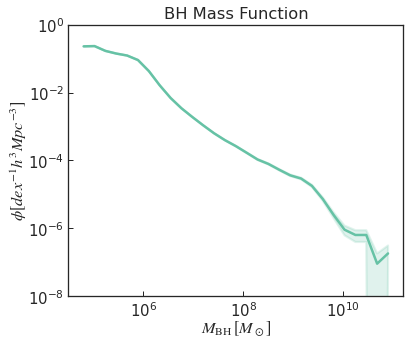

In [56]:
x1,y1,y_lower,y_upper = mass_func(BHMass,Lbox=Lbox/1000,lim_min=4.7,lim_max=11,nbin=30)
fig,ax = plt.subplots(figsize=(6,5),ncols=1,nrows=1)
ax.plot(x1,y1,c=cmap(0))
ax.fill_between(x1,y_lower,y_upper,color=cmap(0),alpha=0.2)
ax.set(xscale='log',yscale='log',ylim=[1e-8,1],\
       xlabel=r'$M_{\rm BH}\,[M_\odot]$',ylabel=r'$\phi [dex^{-1} h^3 Mpc^{-3}]$')
ax.set_title('BH Mass Function')
plt.show()

### example.2 fetch all particles in a group

In [57]:
# This helps you locate particles of each type if you know the group index
Length = pig.open('FOFGroups/LengthByType')[:1000000]
OffsetByType = np.cumsum(Length,axis=0)
a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
OffsetByType = np.append(a1,OffsetByType,axis=0)

In [58]:
# "5" means BH particles, "ID" means we are loading the ID of each BH particle
# here we only load the first 1000000, because most of the massive BHs are there
BHIDs = pig.open('5/ID')[:1000000]

# pick a fairly massive black hole as an example
id1 = 258052176737
idx1 = (BHIDs==id1).nonzero()[0][0]
print('ID of the BH of interest:',id1)

ID of the BH of interest: 258052176737


In [59]:
# from now on we can read BH information only at these two indices:
group1 = pig.open('5/GroupID')[idx1]
gidx=group1-1
print('FOF GroupID of the BH:',group1)
print('GroupIdx:', gidx)

FOF GroupID of the BH: 253
GroupIdx: 252


In [60]:
# BH is in the group with GroupID=3
# Now let's look at other information from Group3
# gidx = group1-1 # groupID starts from 1, but python array index start from 0

# FOFGroups stores some reduced group information
mass_group = pig.open('FOFGroups/MassByType')[gidx]*1e10/hh # 
print("Total mass of [Gas,DM,_,_,Star,BH] in Msun:\n",mass_group)

Total mass of [Gas,DM,_,_,Star,BH] in Msun:
 [2.96869450e+12 2.38535266e+13 0.00000000e+00 0.00000000e+00
 5.63561227e+11 7.50309470e+09]


In [61]:
# this is the starting and ending indices of particles in group2
start,end = OffsetByType[gidx],OffsetByType[gidx+1]
print(start, end)

print(start.shape)
print('Gases in Group start at %d and end at %d'%(start[0],end[0]))
print('DMs in Group start at %d and end at %d'%(start[1],end[1]))
print('Stars in Group start at %d and end at %d'%(start[4],end[4]))
print('BHs in Group start at %d and end at %d'%(start[5],end[5]))

[672986476 918871967         0         0 837020934    124727] [674616625 921266605         0         0 839277674    125062]
(6,)
Gases in Group start at 672986476 and end at 674616625
DMs in Group start at 918871967 and end at 921266605
Stars in Group start at 837020934 and end at 839277674
BHs in Group start at 124727 and end at 125062


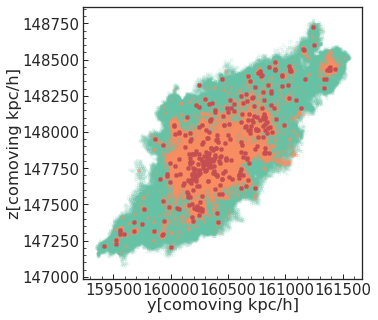

In [62]:
# pos1 = pig.open('1/Position')[start[1]:end[1]]
pos0 = pig.open('0/Position')[start[0]:end[0]]
pos4 = pig.open('4/Position')[start[4]:end[4]]
pos5 = pig.open('5/Position')[start[5]:end[5]]

fig = plt.figure(figsize=(5,5))
plt.scatter(pos0[:,1],pos0[:,2],s=0.01)
plt.scatter(pos4[:,1],pos4[:,2],s=0.05)
plt.scatter(pos5[:,1],pos5[:,2],s=10,marker='x',color='r')

plt.xlabel('y[comoving kpc/h]')
plt.ylabel('z[comoving kpc/h]')
plt.show()

## BH details

In [21]:
# These arrays are necessary for locating a BH in the detials file
path = '/hildafs/datasets/Asterix/BH_details_dict/Read-Blackhole-Detail'
detail = BigFile(path)
AllIDs = detail.open('BHID')[:]
Index = detail.open('Index')[:]

In [22]:
# list of all mergers to help resolve the massive progenitor issue
mergers = np.load('/hildafs/datasets/Asterix/BH_details_bigfile/ASTRID-merger-catalog-z2.npy')
def get_mergers(bhid):
    mask = mergers['ID1'] == bhid
    mask |= mergers['ID2'] == bhid
    return mergers[mask]

### fetch the full history of a BH

We start by working with a single BH's history. Let's take the same BH as in Sec 2.2 as an example.

$\color{red}{\text{Note: when two black holes merge, we only save the information of the BH with the larger ID afterwards. The small ID BH is "swallowed".}}$

In [64]:
bhidx1=idx1

id1 = pig.open('5/ID')[bhidx1]
bhmass = pig.open('5/BlackholeMass')[bhidx1]*1e10/hh

print('ID of the BH of interest:',id1)
print(r'Blackhole Mass %.2e Msun'%bhmass)

ID of the BH of interest: 258052176737
Blackhole Mass 1.84e+07 Msun


In [65]:
def get_bh_history(bhid,trace_massive=False):
    mgs = get_mergers(bhid)
    
    def get_bh(bhid):
        idx = (AllIDs==bhid).nonzero()[0][0]
        chunk = Index[idx]
        # print('File number of the target BHs:',chunk)
        # now load bh data
        outdir = '/hildafs/datasets/Asterix/BH_details_dict/'
        save = outdir+'BlackholeDetails-%04d'%chunk
        with open(save, 'rb') as f:
            data = pickle.load(f)
            f.close()
        bh = data[bhid]
        return bh
        
    if len(mgs) == 0: # no merger to deal with
        return get_bh(bhid)
    
    # find massive progenitors that are swallowed
    mask = (mgs['ID2'] == bhid) & (mgs['ID2']>mgs['ID1'])
    if trace_massive and np.any(mask):
        # look into the past
        mtrace = mgs[mask][np.argmin(mgs[mask]['z'])]
        bh_trace = mtrace['ID1']
        return get_bh_history(bh_trace,trace_massive=True)

    # only look into the future
    
    bh = get_bh(bhid)
    zend = min(bh['z'])
    
    mask = np.maximum(mgs['ID1'],mgs['ID2']) > bhid
    
    if np.any(mask):
        id2 = max(mgs[mask][0]['ID1'],mgs[mask][0]['ID2'])
        zmerge = mgs[mask][0]['z']
        bh2 = get_bh_history(id2,trace_massive=False)
        bh = np.concatenate([bh[bh['z']>zmerge],bh2[bh2['z']<=zmerge]])
    return bh

In [66]:
bh = get_bh_history(bhid=id1,trace_massive=False)

In [67]:
print('Available columns of BHdetails:')
print(bh.dtype.names)

Available columns of BHdetails:
('BHID', 'BHMass', 'acBHMass', 'BHpos', 'BHvel', 'Density', 'DFAccel', 'Fdbk', 'Entropy', 'Mdot', 'Swallowed', 'SwallowID', 'encounter', 'z')


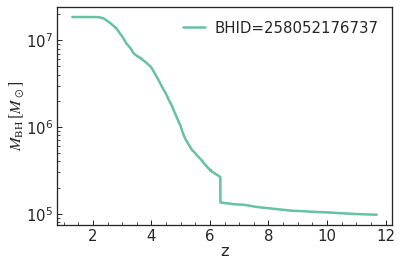

In [68]:
plt.plot(bh['z'],bh['BHMass']*1e10/hh,label='BHID=%d'%id1)
plt.yscale('log')
plt.xlabel('z')
plt.ylabel(r'$M_{\rm BH}\,[M_\odot]$')
plt.legend()
plt.show()

### interation between a pair

#### some auxilliary functions to plot pair histories

In [70]:
c_mks = 3e8
msun_mks = 2e30
s_to_year = 3.17098e-8
year_to_s = 1./s_to_year
lsun_ergs = 3.9e33
mdot_msun_yr = 1e10/980/1e6
def calc_lx(mdot):
    """
    input: mdot in Msun/yr
    output: Lx in ergs
    """
    lbol = 0.1*mdot*msun_mks/year_to_s*c_mks**2
    lbol_lsun = lbol/3.9e26
    k = 10.83*(lbol_lsun/1e10)**0.28 \
        + 6.08*(lbol_lsun/1e10)**(-0.02)
    return lbol/k*1e7

def calc_lbol(mdot):
    """
    input: mdot in Msun/yr
    output: Lx in ergs
    """
    lbol = 0.1*mdot*msun_mks/year_to_s*c_mks**2
    lbol_ergs = lbol*1e7
    return lbol_ergs
def density_to_msunpc3(a): # density in mass/len^3 unit
    mass_msun = 1e10/hh
    length_pc = a*1000/hh
    rho = mass_msun/(length_pc)**3
    return rho

In [71]:
def calc_vel(bh,z,fv='extrapolate',kind = 'linear'):
    fx = interp1d(bh['z'],bh['BHvel'][:,0],fill_value=fv,kind = kind)
    fy = interp1d(bh['z'],bh['BHvel'][:,1],fill_value=fv,kind = kind)
    fz = interp1d(bh['z'],bh['BHvel'][:,2],fill_value=fv,kind = kind)
    return np.array([fx(z),fy(z),fz(z)])

def calc_pos2(bh,z,fv='extrapolate',kind = 'linear'):
    fx = interp1d(bh['z'],bh['BHpos'][:,0],fill_value=fv,kind = kind)
    fy = interp1d(bh['z'],bh['BHpos'][:,1],fill_value=fv,kind = kind)
    fz = interp1d(bh['z'],bh['BHpos'][:,2],fill_value=fv,kind = kind)
    return np.array([fx(z),fy(z),fz(z)])

def edd_ratio(mass,lum):
    return lum/(1.26e38*mass)


In [72]:
def plot_pair(bh1,bh2,zmerge,save=None):
    t1 = z_to_t(bh1['z'])
    t2 = z_to_t(bh2['z'])
    a1 = 1./(bh1['z']+1.)
    a2 = 1./(bh2['z']+1.)
    lbol1 = calc_lbol(bh1['Mdot']*mdot_msun_yr)
    lbol2 = calc_lbol(bh2['Mdot']*mdot_msun_yr)
    zz = np.linspace(zmerge-0.2,zmerge+1.5,2000)
    tt = z_to_t(zz)
    
    v1 = calc_vel(bh1,zz)
    v2 = calc_vel(bh2,zz)
    dv = np.linalg.norm(v1-v2,axis=0)
    
    dr = np.linalg.norm(calc_pos2(bh1,zz) - calc_pos2(bh2,zz),axis=0)/(zz+1)/hh
    
    fig,ax = plt.subplots(figsize=(9,7),ncols=1,nrows=4,sharex=True)
    plt.subplots_adjust(hspace=0.)
    plt.subplots_adjust(left=0.07, right=0.99, top=0.92, bottom=0.14)
    ax[0].plot(t1,lbol1,color='r',label='BH1:%d'%bh1['BHID'][0])
    ax[0].plot(t2,lbol2,color='b',label='BH2:%d'%bh2['BHID'][0])
    
    ax[1].plot(t1,bh1['Density']*density_to_msunpc3(a1),color='r')
    ax[1].plot(t2,bh2['Density']*density_to_msunpc3(a2),color='b',label='BH2:%d'%bh2['BHID'][0])
    
    ax[2].plot(t1,bh1['BHMass']*1e10/hh,color='r',label='BH1:%d'%bh1['BHID'][0])
    ax[2].plot(t2,bh2['BHMass']*1e10/hh,color='b',label='BH2:%d'%bh2['BHID'][0])
    ax[0].legend()
    
    mask = zz>=zmerge
    ax[3].plot(tt[mask],dr[mask],color='b')
    
    ax[0].set(yscale='log',ylabel=r'$L_{\rm bol}[erg/s]$')
    ax[1].set(yscale='log',ylabel=r'$\rho_{\rm gas}[M_\odot/pc^3]$')
    ax[2].set(yscale='log',ylabel=r'$M_{\rm bh}\,[M_\odot]$')
    ax[3].set(ylabel=r'$\Delta r [kpc]$',xlabel='Time[Gyr]',xlim=[1.7,2.8],yscale='log')
    
    for i in range(4):
        ax[i].axvline(z_to_t(zmerge),linestyle='--',color='grey',linewidth=1.2,label=r'$z_{\rm merge}=%.2f$'%zmerge)
    ax[3].legend()
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()
    

#### read in a pair

In [73]:
# take a random massive pair from MBH merger events
mfile = '/hildafs/datasets/Asterix/BH_details_bigfile/mdata-z3z24/mdata/bh-merger-R239.npy'
merger = np.load(mfile)
print(merger.dtype)

# find a relatively massive merger
mask = (merger['m1']>5e6) & (merger['m2']>1e6)
massive_merger = merger[mask]

[('z', '<f8'), ('ID1', '<i8'), ('ID2', '<i8'), ('m1', '<f8'), ('m2', '<f8')]


In [74]:
# get bh histories without tracing the massive progenitor
pair = massive_merger[20]
id1,id2 = pair['ID1'],pair['ID2']

bh1 = get_bh_history(id1)
bh2 = get_bh_history(id2)

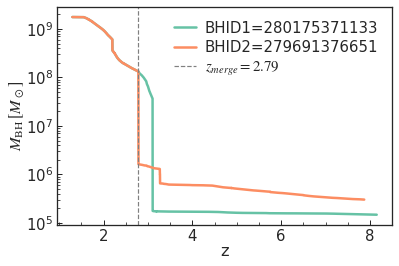

In [75]:
plt.plot(bh1['z'],bh1['BHMass']*1e10/hh,label='BHID1=%d'%id1)
plt.plot(bh2['z'],bh2['BHMass']*1e10/hh,label='BHID2=%d'%id2)

plt.axvline(pair['z'],linestyle='--',linewidth=1.2,color='grey',label=r'$z_{merge}=%.2f$'%pair['z'])
plt.yscale('log')
plt.xlabel('z')
plt.ylabel(r'$M_{\rm BH}\,[M_\odot]$')
plt.legend()
plt.show()

We see a big jump in the mass of BH1 around z=3, meaning that it has swllowed a BH much heavier than itself. 

Now we trace the more massive progenitor.

In [34]:
# trace bh histories with massive progenitor
pair = massive_merger[20]
id1,id2 = pair['ID1'],pair['ID2']

bh1 = get_bh_history(id1,trace_massive=True)
bh2 = get_bh_history(id2,trace_massive=True)

now there is not a big bump in the green curve because we found its massive progenitor

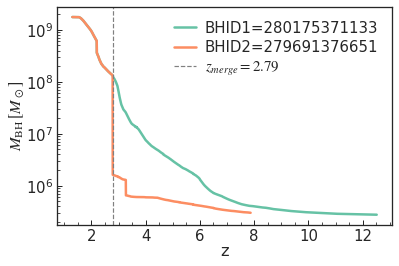

In [35]:

plt.plot(bh1['z'],bh1['BHMass']*1e10/hh,label='BHID1=%d'%id1)
plt.plot(bh2['z'],bh2['BHMass']*1e10/hh,label='BHID2=%d'%id2)

plt.axvline(pair['z'],linestyle='--',linewidth=1.2,color='grey',label=r'$z_{merge}=%.2f$'%pair['z'])
plt.yscale('log')
plt.xlabel('z')
plt.ylabel(r'$M_{\rm BH}\,[M_\odot]$')
plt.legend()
plt.show()

plot more quantities before and after the MBH merger

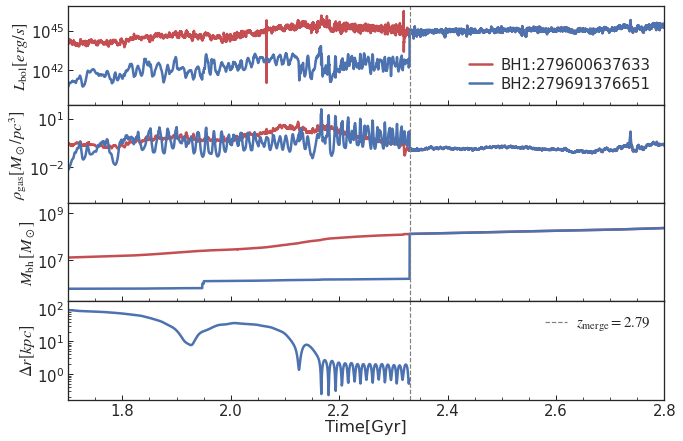

In [36]:
plot_pair(bh1,bh2,zmerge=pair['z'])

#### plot the orbits

In [37]:
def get_projection_mean(dp,dv):
    j = np.cross(dv,dp,axis=0)
    
    j = np.mean(j/np.linalg.norm(j,axis=0),axis=1) # normal vector
    # basis on the plane
    e1 = np.array([-j[1],j[0],0])
    e1 /= np.linalg.norm(e1)
    e2 = np.array([j[0],j[1],-(j[0]**2+j[1]**2)/j[2]])
    e2 /= np.linalg.norm(e2)
    return e1,e2

def plot_orbit(bh1,bh2,zmerge,dz1 = 0.03,dz2 = 0.5,e1 = None, e2 = None,save=None):
    t1 = z_to_t(bh1['z'])
    t2 = z_to_t(bh2['z'])
    a1 = 1./(bh1['z']+1.)
    a2 = 1./(bh2['z']+1.)

    zz = np.linspace(zmerge+dz1,zmerge+dz2,2000)
    tt = z_to_t(zz)
    
    v1 = calc_vel(bh1,zz)
    v2 = calc_vel(bh2,zz)
    dv = v1-v2

    
    dp = (calc_pos2(bh1,zz) - calc_pos2(bh2,zz))/(zz+1)/hh
    
    if e1 is None:
        e1,e2 = get_projection_mean(dp,dv)
    
    
    fig,ax = plt.subplots(figsize=(6,6),ncols=1,nrows=1,sharex=True)
    plt.subplots_adjust(hspace=0.)
    
    ax.plot(e1@dp,e2@dp)
    ax.set(xlabel='x1 [kpc]',ylabel='x2 [kpc]')
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()
    
def plot_orbit_com(bh1,bh2,zmerge,dz1 = 0.03,dz2 = 0.5,e1 = None, e2 = None,save=None):
    t1 = z_to_t(bh1['z'])
    t2 = z_to_t(bh2['z'])
    a1 = 1./(bh1['z']+1.)
    a2 = 1./(bh2['z']+1.)

    zz = np.linspace(zmerge+dz1,zmerge+dz2,2000)
    tt = z_to_t(zz)
    
    v1 = calc_vel(bh1,zz)
    v2 = calc_vel(bh2,zz)
    dv = v1-v2
    
    pos1 = calc_pos2(bh1,zz)/(zz+1)/hh
    pos2 = calc_pos2(bh2,zz)/(zz+1)/hh

    m1 = np.interp(zz,bh1['z'],bh1['BHMass'])
    m2 = np.interp(zz,bh2['z'],bh2['BHMass'])
    
    com = m1/(m1+m2)*pos1 + m2/(m1+m2)*pos2
    dp1 = pos1 - com
    dp2 = pos2 - com
    
    dp = pos1-pos2
    
    if e1 is None:
        e1,e2 = get_projection_mean(dp,dv)
    
    fig,ax = plt.subplots(figsize=(6,6),ncols=1,nrows=1,sharex=True)
    plt.subplots_adjust(hspace=0.)
    
    ax.plot(e1@dp1,e2@dp1)
    ax.plot(e1@dp2,e2@dp2)
    ax.set(xlabel='x1 [kpc]',ylabel='x2 [kpc]')
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()

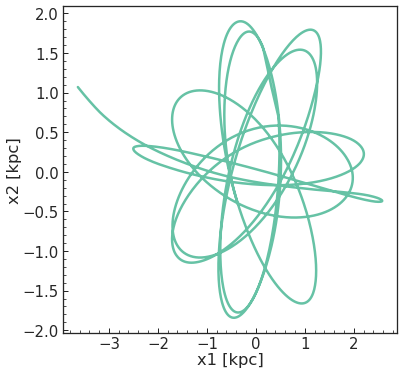

In [38]:
# orbit of BH2 wrt BH1
plot_orbit(bh1,bh2,zmerge=pair['z'],dz1 = 0.001,dz2 = 0.2,save=None)

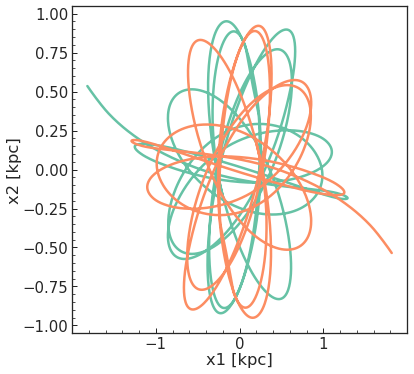

In [39]:
# orbits of two BHs wrt center of mass
plot_orbit_com(bh1,bh2,zmerge=pair['z'],dz1 = 0.001,dz2 = 0.2,save=None)

## Visualization